In [1]:
require 'VGG';
require 'nn';

In [2]:
-- require 'VGG';
-- VGG_net = load_VGG();
-- print('VGGnet5\n' .. VGG_net:__tostring());

In [3]:
-- local layer_nums = {9,16}
-- local num_images = 20;
-- hc_dataset = create_hypercolumn_dataset(num_images, layer_nums)

##  Loading the data from disk

In [4]:
hc_file_name = '../../Data/tiny-imagenet-200/test/hc/test.t7'
hc_dataset = torch.load(hc_file_name)

In [5]:
hypercolumns = hc_dataset["hypercolumns"]
images = hc_dataset["images"]
print(hypercolumns:size())
num_hypercolumns = hypercolumns:size()[2]
batch_size = hypercolumns:size()[1]

  32
 384
 112
 112
[torch.LongStorage of size 4]



## Converting the data labels from rgb to uv format

In [6]:
local yuv_temp = image.rgb2yuv(images[1]);
yuv_temp = image.scale(yuv_temp,28,28,'bilinear')
local uv_temp = yuv_temp[{{2,3}}]
local y_temp = yuv_temp[{{1}}]
uv_temp = uv_temp:reshape(1,uv_temp:size()[1], uv_temp:size()[2], uv_temp:size()[3] );
y_temp = y_temp:reshape(1,y_temp:size()[1], y_temp:size()[2], y_temp:size()[3] );
uv_images = uv_temp
y_images = y_temp

for count=2,batch_size do
    yuv_temp = image.rgb2yuv(images[count]);
    yuv_temp = image.scale(yuv_temp,28,28,'bilinear')
    uv_temp = yuv_temp[{{2,3}}]
    y_temp = yuv_temp[{{1}}]
    
    uv_temp = uv_temp:reshape(1,uv_temp:size()[1], uv_temp:size()[2], uv_temp:size()[3]);
    y_temp = y_temp:reshape(1,y_temp:size()[1], y_temp:size()[2], y_temp:size()[3] );
    
    uv_images = torch.cat(uv_images,uv_temp,1)
    y_images = torch.cat(y_images,y_temp,1)
end
    print(uv_images:size())

 32
  2
 28
 28
[torch.LongStorage of size 4]



## Initializing the trainset datastructure.
The format should be as follows
1) Trainset.data = contains **X minibatches**

In [7]:
print(y_images:size())

 32
  1
 28
 28
[torch.LongStorage of size 4]



In [8]:
trainset={};
trainset.data = torch.Tensor(1, hypercolumns:size()[1],hypercolumns:size()[2],hypercolumns:size()[3],hypercolumns:size()[4])
trainset.label = torch.Tensor(1,uv_images:size()[1],uv_images:size()[2],uv_images:size()[3],uv_images:size()[4])
function trainset:size() return hypercolumns:size()[1] end -- 100 examples
for i=1,trainset:size() do 
  trainset.data[1][i] = hypercolumns[i]
  trainset.label[1][i] = uv_images[i] 
end

setmetatable(trainset, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
);
trainset.data = trainset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.

function trainset:size() 
    return self.data:size(1) 
end

In [9]:
require "nn"
require "torch"

function BasicConvNet1()
    -- Number of filters in different layers 
    net = nn.Sequential()
    HyperColumnHeight = num_hypercolumns
    Layer1FilterNum = 32
    Layer2FilterNum = 64
    Layer3FilterNum = 2


    -- [[ Layer 1 ]]
    -- HyperColumnHeight input image channel, Layer1FilterNum output channels, 3x3 convolution kernel, 1 stride W, 1 stride H, 1 pad W, 1 pad R
    net:add(nn.SpatialConvolution(HyperColumnHeight, Layer1FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Batch Normalization
    net:add(nn.SpatialBatchNormalization(Layer1FilterNum))                       
    -- ReLU non-linearity
    net:add(nn.ReLU())
    -- 2x2 max-pooling
    net:add(nn.SpatialMaxPooling(2,2,2,2))


    -- [[ Layer 2 ]]
    -- Layer1FilterNum input image channel, Layer2FilterNum output channels, 3x3 convolution kernel, 1 stride W, 1 stride H, 1 pad W, 1 pad R
    net:add(nn.SpatialConvolution(Layer1FilterNum, Layer2FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Batch Normalization
    net:add(nn.SpatialBatchNormalization(Layer2FilterNum))                       
    -- ReLU non-linearity
    net:add(nn.ReLU())
    -- 2x2 max-pooling
    net:add(nn.SpatialMaxPooling(2,2,2,2))

    --[[ Layer 3 ]]
    -- Layer2FilterNum input image channel, Layer3FilterNum output channels, 3x3 convolution kernel, 1 stride W, 1 stride H, 1 pad W, 1 pad R
    net:add(nn.SpatialConvolution(Layer2FilterNum, Layer3FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Adding transfer function sigmod 
    net:add(nn.Sigmoid())  

    net:zeroGradParameters()
    return net

end


In [10]:
require "nn"
require "torch"

function BasicConvNet2()
    -- Number of filters in different layers 
    net = nn.Sequential()
    HyperColumnHeight = num_hypercolumns
    Layer1FilterNum = 32
    Layer2FilterNum = 64
    Layer3FilterNum = 2


    -- [[ Layer 1 ]]
    -- HyperColumnHeight input image channel, Layer1FilterNum output channels, 3x3 convolution kernel, 1 stride W, 1 stride H, 1 pad W, 1 pad R
    net:add(nn.SpatialConvolution(HyperColumnHeight, Layer1FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Batch Normalization
    net:add(nn.SpatialBatchNormalization(Layer1FilterNum))                       
    -- ReLU non-linearity
    net:add(nn.ReLU())
    
    net:add(nn.SpatialConvolution(Layer1FilterNum, Layer1FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Batch Normalization
    net:add(nn.SpatialBatchNormalization(Layer1FilterNum))                       
    -- ReLU non-linearity
    net:add(nn.ReLU())
    
    net:add(nn.SpatialConvolution(Layer1FilterNum, Layer1FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Batch Normalization
    net:add(nn.SpatialBatchNormalization(Layer1FilterNum))                       
    -- ReLU non-linearity
    net:add(nn.ReLU())
    
    -- 2x2 max-pooling
    net:add(nn.SpatialMaxPooling(2,2,2,2))


    -- [[ Layer 2 ]]
    -- Layer1FilterNum input image channel, Layer2FilterNum output channels, 3x3 convolution kernel, 1 stride W, 1 stride H, 1 pad W, 1 pad R
    net:add(nn.SpatialConvolution(Layer1FilterNum, Layer2FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Batch Normalization
    net:add(nn.SpatialBatchNormalization(Layer2FilterNum))                       
    -- ReLU non-linearity
    net:add(nn.ReLU())
    
     net:add(nn.SpatialConvolution(Layer2FilterNum, Layer2FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Batch Normalization
    net:add(nn.SpatialBatchNormalization(Layer2FilterNum))                       
    -- ReLU non-linearity
    net:add(nn.ReLU())
    
     net:add(nn.SpatialConvolution(Layer2FilterNum, Layer2FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Batch Normalization
    net:add(nn.SpatialBatchNormalization(Layer2FilterNum))                       
    -- ReLU non-linearity
    net:add(nn.ReLU())
    -- 2x2 max-pooling
    net:add(nn.SpatialMaxPooling(2,2,2,2))

    --[[ Layer 3 ]]
    -- Layer2FilterNum input image channel, Layer3FilterNum output channels, 3x3 convolution kernel, 1 stride W, 1 stride H, 1 pad W, 1 pad R
    net:add(nn.SpatialConvolution(Layer2FilterNum, Layer3FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Adding transfer function sigmod 
    net:add(nn.Sigmoid())  

    net:zeroGradParameters()
    return net

end

In [11]:
-- require('Net1')

In [17]:
-- Loading the net
net = BasicConvNet1()
-- net = BasicConvNet2()

print('ConvNet Loaded')

-- Defining a loss function
Weight = torch.ones(2,28,28)-- All ones matrix -- Bad coding
criterion = nn.WeightedMSECriterion(Weight)
print('MSEcriterion defined')

trainer = nn.StochasticGradient(net, criterion)
-- learning rate init
trainer.learningRate = 5 -- This can be further increased
-- Number of Epocs
trainer.maxIteration = 3
trainer.verbose = true
trainer.shuffleIndices = false
trainer.learningRateDecay = .9
print('Trainer defined')

ConvNet Loaded	
MSEcriterion defined	
Trainer defined	


In [13]:
-- Passing a random input
input = torch.rand(2,384,112,112) -- pass a random tensor as input to the network
-- Obtain the output
output = net:forward(input)

-- Checking the backward pass using a fake expected output
ExpectedFakeOutput = torch.rand( output:size() )
criterion:forward(output, ExpectedFakeOutput)
gradients = criterion:backward(output, ExpectedFakeOutput)
print("No code error during sanity check (Logical error might still exist)")

No code error during sanity check (Logical error might still exist)	


In [15]:
require 'copy'
prev_net = copy3(net)

## Network output before training

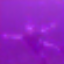

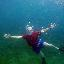

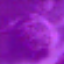

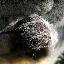

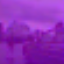

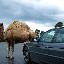

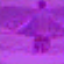

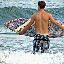

In [16]:
require 'copy'
a = prev_net:forward(hypercolumns)
i = 1
itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],a[i],1)), 64,64))
itorch.image(images[i] )

print('\n')
i = 4
itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],a[i],1)), 64,64))
itorch.image(images[i] )

print('\n')
i = 8
itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],a[i],1)), 64,64))
itorch.image(images[i] )

print('\n')
i = 16
itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],a[i],1)), 64,64))
itorch.image(images[i] )


In [ ]:
print('The training starts')
-- Woah! Traingin the data
trainer:train(trainset)
--torch.save('../Models/Overfit', net)

The training starts	


# StochasticGradient: training	


In [17]:
b = net:forward(hypercolumns)


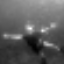

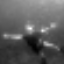

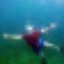

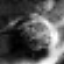

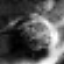

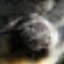

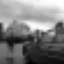

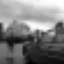

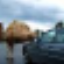

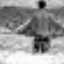

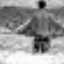

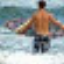

In [18]:

i = 1
itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],a[i],1)), 64,64))

itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],b[i],1)), 64,64))
itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_images[i],1)), 64,64))

print('\n')
i = 4
itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],a[i],1)), 64,64))
itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],b[i],1)), 64,64))
itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_images[i],1)), 64,64))

print('\n')
i = 8
itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],a[i],1)), 64,64))
itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],b[i],1)), 64,64))
itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_images[i],1)), 64,64))

print('\n')
i = 16
itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],a[i],1)), 64,64))
itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],b[i],1)), 64,64))
itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_images[i],1)), 64,64))


In [19]:
for i=1,16 do    
    print('\n')
    A = image.scale(image.yuv2rgb(torch.cat(y_images[i],a[i],1)), 64,64)
    B = image.scale(image.yuv2rgb(torch.cat(y_images[i],b[i],1)), 64,64)
    itorch.image(A)
    itorch.image(B)
end

/home/kedart/torch/install/share/lua/5.1/image/init.lua:388: attempt to concatenate local 'ext' (a nil value)
stack traceback:
	/home/kedart/torch/install/share/lua/5.1/image/init.lua:388: in function 'save'
	[string "for i=1,16 do    ..."]:5: in main chunk
	[C]: in function 'xpcall'
	/home/kedart/torch/install/share/lua/5.1/itorch/main.lua:209: in function </home/kedart/torch/install/share/lua/5.1/itorch/main.lua:173>
	/home/kedart/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/home/kedart/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/home/kedart/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/home/kedart/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/home/kedart/torch/install/share/lua/5.1/itorch/main.lua:381: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00406670: 